### Reinforcement Learning

 In reinforcement learning, an agent interacts with the environment, experiencing a series of rewards based on its actions. The agent seeks to maximize its rewards by developing a strategy that learns to choose appropriate actions in each state.


<img src="https://raw.githubusercontent.com/YData123/sds265-fa21/main/demos/reinforcement-learning/rl_animation.gif" width=300>

<br>

In this notebook we demo the Q-learning algorithm, one of the fundamental algorithms of reinforcement learning.
We illustrate Q-learning on the taxicab problem formulated by Tom Dietterich in the paper "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition", as developed in the code
from [OpenAI gym](https://github.com/openai). Our presentation follows [this tutorial](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/).

We'll need the OpenAI gym package. This can be installed as shown below. We'll display some simple graphics using `IPython.display`.

In [60]:
#!pip install gymnasium
#!pip install pygame
import gymnasium as gym
import numpy as np
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline


In [61]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
_ = pygame.display.set_mode((640,480))

The environment is a simple grid, with some barriers inserted to make things more interesting. A taxicab drives around the environment, picking up and delivering a passenger at four locations. A graphic of the environment is shown below.

<img src="https://raw.githubusercontent.com/YData123/sds265-fa21/main/demos/reinforcement-learning/taxi-shot.png" width=200>

The "ascii art" rendition of this environment appears as shown in the following output cell:

In [62]:
env = gym.make("Taxi-v3", render_mode='ansi').env
env.reset()
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




As described in the documentation,
"there are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends."

With 25 taxi positions, 4 possible locations of the passenger waiting,
the case where the passenger is in the taxi, and 4 possible destination
locations, the total number of states is $25\times 5 \times 4 = 500$.

The passenger location are coded as integers in the following way:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

And the destinations are coded as:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

Finally, there are 6 possible actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

There is a default per-step reward of -1,
and a reward of +20 for delivering the passenger.
Carrying out a "pickup" or "drop-off" action illegally has
a reward of -10.

In the ascii art graphics, the following color schemes are used:
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters (R, G, Y and B): locations for passengers and destinations

The state space is represented as a tuple in the following way:
    
    
    state = (taxi_row, taxi_col, passenger_location, destination)

#### Exploring randomly

We first look at the obviously terrible strategy of selecting
a random action at each time step.

In [63]:
# Some helper functions for visualizing the sequence of states and actions

def render(env, stat, action, reward):
    return {'frame': env.render(),
            'state': stat,
            'action': action,
            'reward': reward}


def print_frames(frames, delay=.1):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(delay)

In [64]:
env.s = 328
epochs = 0
penalties, reward = 0, 0
frames = []

done = False
while not done:
    action = env.action_space.sample() # choose a random action
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1

    frames.append(render(env, state, action, reward))
    epochs += 1


print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1920
Penalties incurred: 628


As can be seen, the taxi wanders around randomly, banging into walls, picking up and dropping off the passenger at wrong places, and incurring large negative rewards.

In [65]:
print_frames(frames[0:100], delay=.1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 100
State: 322
Action: 3
Reward: -1


### Using Q-learning

We'll now learn a strategy using the Q-learning algorithm.
The Q-learning algorithm maintains a "quality" variable $Q(s,a)$ for taking action $a$ in state $s$. This is a measure of the cumulative
rewards obtained by the algorithm when it takes action $a$ in state $s$.

The quality should not be assessed
purely based on the reward the action has in the current time step.
Rather, we need to take into account the future rewards that the algorithm in driving toward the goal.

As described in lecture, the quality function is updated
as follows:

\begin{align*}
Q(s,a) \longleftarrow (1-\alpha)\,Q(s,a) + \alpha \left(
\mbox{reward}(s,a) + \gamma \max_{a'} Q(\mbox{next}(s,a), a')\right)
\end{align*}

Here $s$ is the current state. When action $a$ is taken,
a reward $\mbox{reward}(s,a)$ is given. Then, the algorithm
moves to a new state, denoted $\mbox{next}(s,a)$. For example,
if the taxi is at location $(2,2)$ and takes the "West" action
($a=3$), then there is a reward of -1, and the taxi moves
to the new location $(2,3)$. If the cab is empty, it remains empty, and if it contains the passenger, the passenger remains.

The cumulative future rewards of this action are given by the expression
$\max_{a'} Q(\mbox{next}(s,a), a')$. These future rewards are discounted by a factor $\gamma < 1$. This trades off short-term against long-term rewards. When $\gamma$ is small, the short-term rewards are favored.

Note that this update can be rewritten as follows:

\begin{align*}
Q(s,a) \longleftarrow \,Q(s,a) + \alpha \left(
\mbox{reward}(s,a) + \gamma \max_{a'} Q(\mbox{next}(s,a), a') - Q(s,a)\right)
\end{align*}

This form suggests that it can be viewed as a gradient *ascent* algorithm, with $\alpha$ as the step size. In fact, it can be shown that with descreasing step size the algorithm will converge, just as for stochastic gradient descent.

In [69]:
import random
from tqdm import tqdm

alpha = 0.1
gamma = 0.8
epsilon = 0.1
episodes = 20000
q_table = np.zeros([env.observation_space.n, env.action_space.n])

for _ in tqdm(np.arange(episodes)):
    state, info = env.reset()

    done = False
    while not done:
        greedy = True
        if random.uniform(0, 1) < epsilon:
            greedy = False
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, truncated, info = env.step(action)

        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = old_value + alpha*(reward + gamma * next_max - old_value)
        q_table[state, action] = new_value

        state = next_state


100%|██████████| 20000/20000 [00:13<00:00, 1467.63it/s]


In [70]:
epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
state, info = env.reset()
done = False

while not done:
    if random.uniform(0, 1) < epsilon:
       action = env.action_space.sample() # Explore action space
    else:
       action = np.argmax(q_table[state]) # Exploit learned values

    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1

    # Put each rendered frame into dict for animation
    frames.append(render(env, state, action, reward))
    epochs += 1

print_frames(frames, delay=.2)

print(f"\nTimesteps taken: {epochs}")
print(f"Penalties incurred: {penalties}")


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 15
State: 85
Action: 5
Reward: 20

Timesteps taken: 15
Penalties incurred: 0


Now replay the trip in 'slow motion'

In [71]:
print_frames(frames, delay=.5)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 15
State: 85
Action: 5
Reward: 20


### Visualizing the value function

Now we compute the value function $v_*(s) = \max_a Q(s,a)$ and visualize this during the taxi trip. We can see how this makes sense as a prediction of future reward.


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



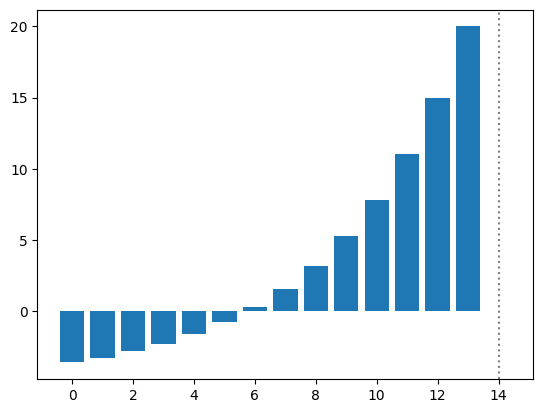

In [72]:
values = [np.max(q_table[frames[i]['state']]) for i in np.arange(len(frames))]

for i in np.arange(len(frames)):
    clear_output(wait=True)
    print(frames[i]['frame'])
    _ = plt.bar(x=np.arange(len(values)), height=values)
    plt.axvline(x=i, c='gray', linestyle='dotted')
    plt.show()
    sleep(.5)



array([[20. , 15. , -1. ,  0.2, -0.8],
       [15. , 11. ,  3.2,  1.6,  0.2],
       [11. ,  7.8,  5.2,  3.2,  1.6],
       [ 7.8,  5.2,  3.2,  1.6,  0.2],
       [ 5.2,  0.2, -1.2,  0.2, -0.8]])

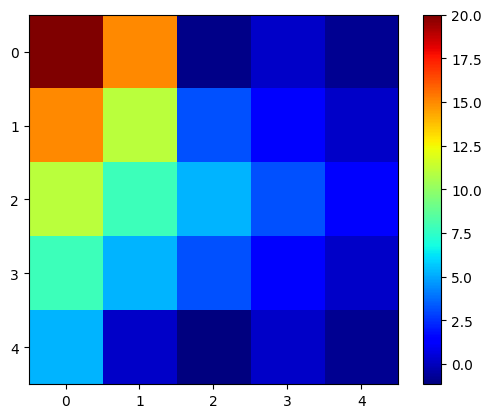

In [73]:
value = np.zeros(25).reshape(5,5)
for i in np.arange(500):
    env.s = i
    taxi_row, taxi_col, passenger_index, destination_index = env.unwrapped.decode(i)
    if (passenger_index==4) and (destination_index==0):
        v = np.max(q_table[i])
        value[taxi_row, taxi_col] = v
        #print(render(env, -1, -1, -1)['frame'])
        #print('row=%d col=%d value=%f' % (taxi_row, taxi_col, v))

plt.imshow(value, cmap='jet')
plt.colorbar()
#plt.savefig('taxi1.jpg', bbox_inches='tight')
np.round(value,1)